# Arena Events

Number of events - 4 times per hour 

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


c:\program files\python35\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


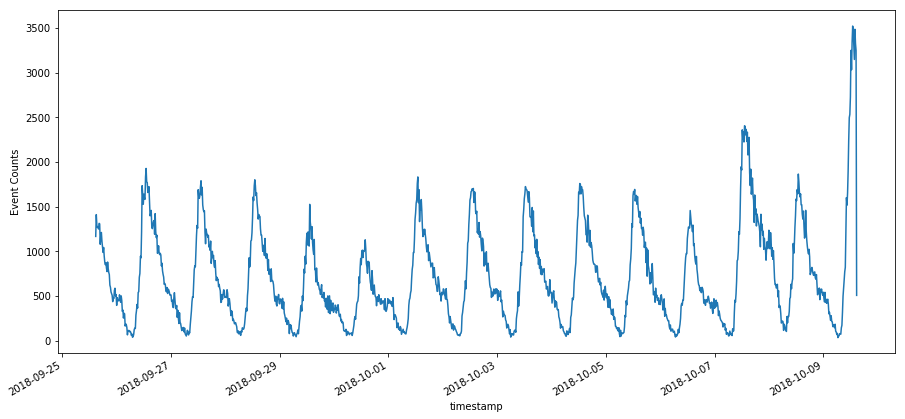

In [2]:
data = pd.read_csv('alerts.csv', ',', index_col=['timestamp'], parse_dates=['timestamp'], dayfirst=True)
plt.figure(figsize(15,7))
data.eventCount.plot()
plt.ylabel('Event Counts')
pylab.show()

In [3]:
data.sort_index(inplace=True)
data["eventCount"] = data["eventCount"].astype(np.float32)
data.info(verbose=True)
#print(data.head(20))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1345 entries, 2018-09-25 14:45:00 to 2018-10-09 14:45:00
Data columns (total 1 columns):
eventCount    1345 non-null float32
dtypes: float32(1)
memory usage: 15.8 KB


In [4]:
period = 24*4

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

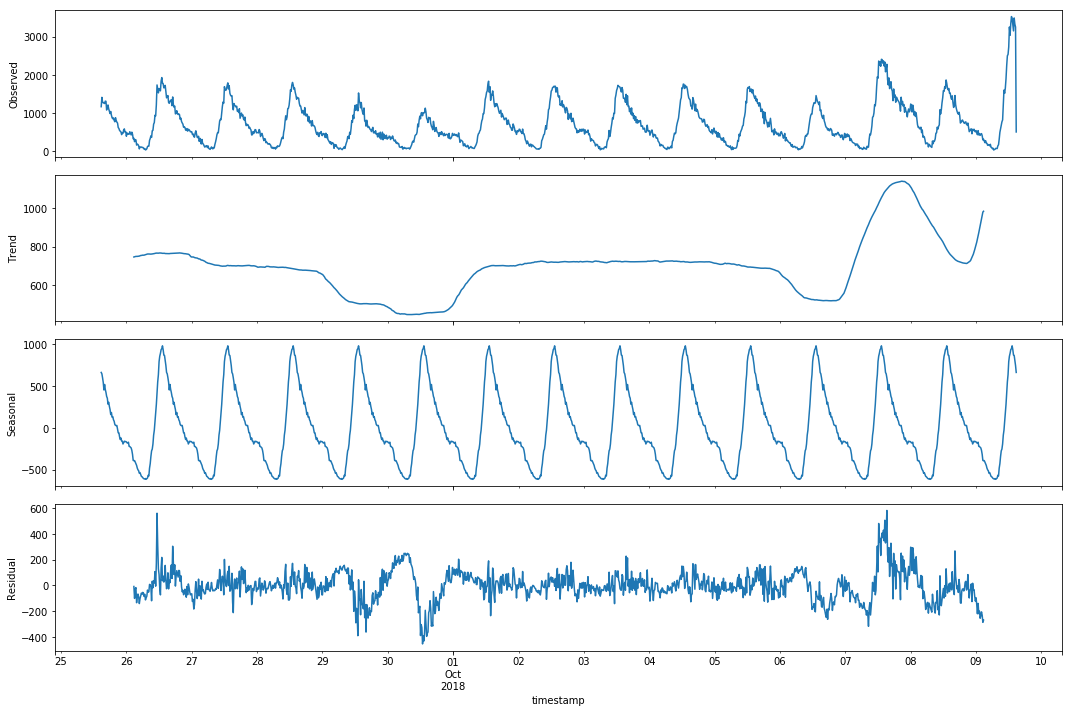

In [5]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data["eventCount"], freq=period).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.eventCount)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

c:\program files\python35\lib\site-packages\scipy\stats\morestats.py:902: RuntimeWarning: overflow encountered in square
  llf -= N / 2.0 * np.log(np.sum((y - y_mean)**2. / N, axis=0))


Оптимальный параметр преобразования Бокса-Кокса: 0.293764
Критерий Дики-Фуллера: p=0.000000


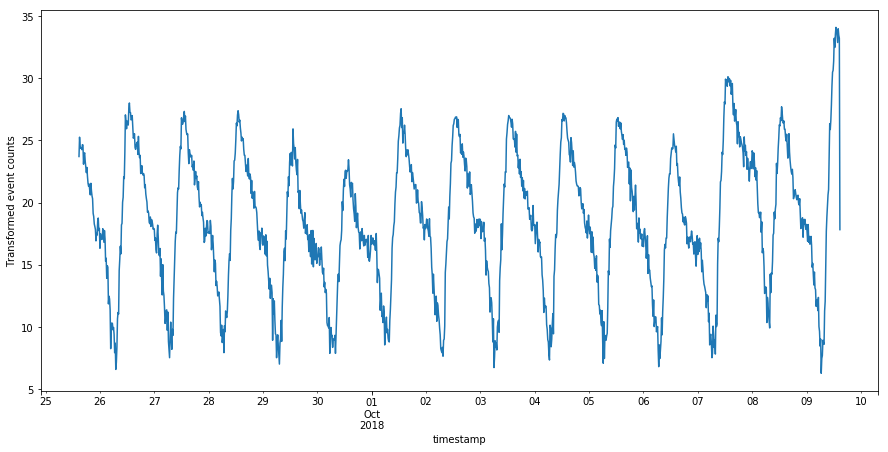

In [6]:
data['eventCount_box'], lmbda = stats.boxcox(data.eventCount)
plt.figure(figsize(15,7))
data.eventCount_box.plot()
plt.ylabel(u'Transformed event counts')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.eventCount_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.001166


<Figure size 1080x720 with 0 Axes>

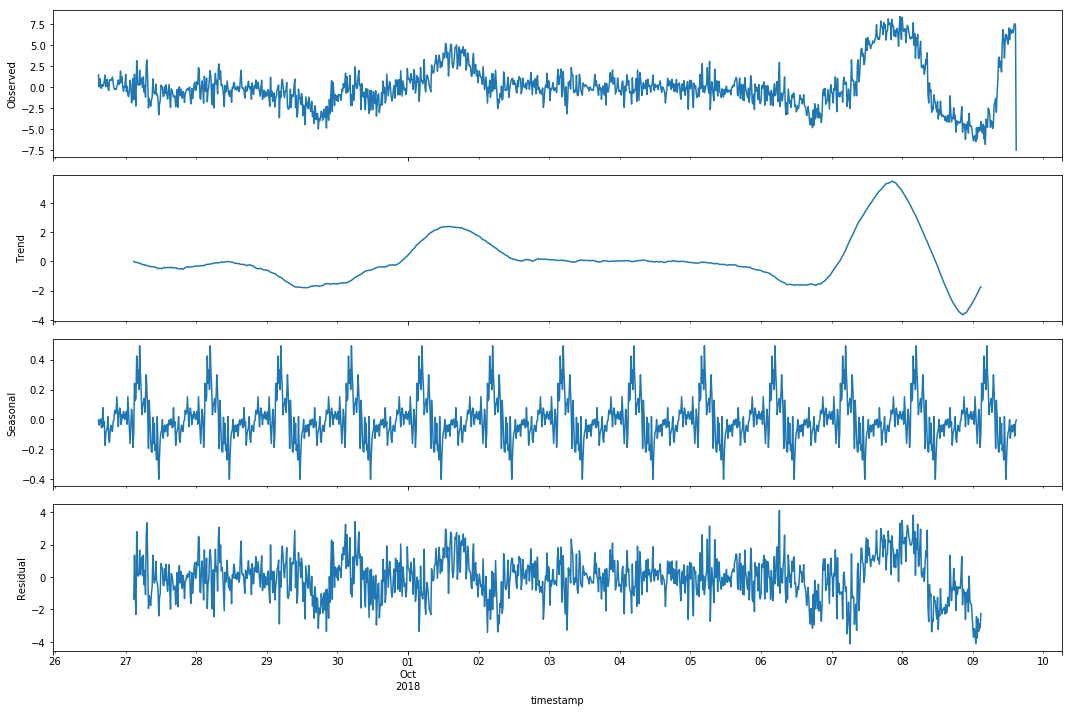

In [7]:
data['eventCount_box_season_diff'] = data.eventCount_box - data.eventCount_box.shift(period)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.eventCount_box_season_diff[period:], freq=period).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.eventCount_box_season_diff[period:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

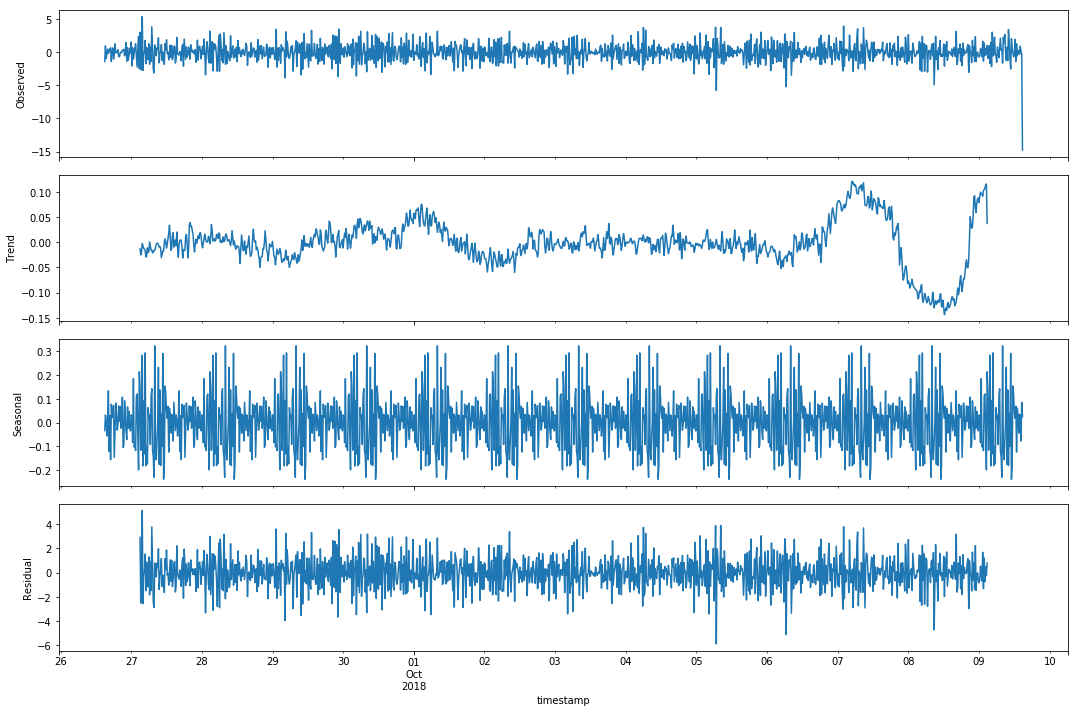

In [8]:
data['eventCount_box_diff2'] = data.eventCount_box_season_diff - data.eventCount_box_season_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(data.eventCount_box_diff2[(period+1):], freq=period).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.eventCount_box_diff2[(period+1):])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

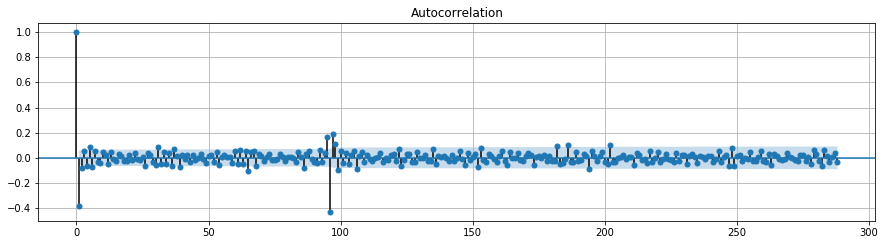

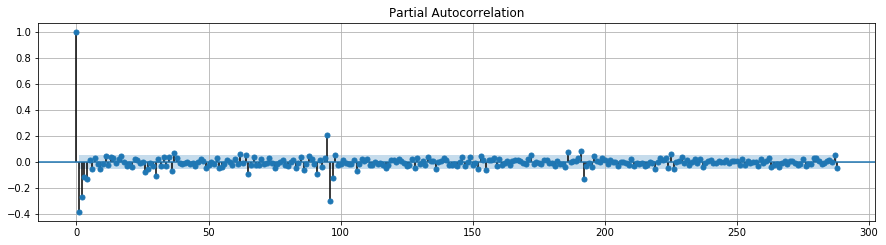

In [9]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.eventCount_box_diff2[(period+1):].values.squeeze(), lags=period*3, ax=ax)
pylab.grid(True)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.eventCount_box_diff2[(period+1):].values.squeeze(), lags=period*3, ax=ax)
pylab.grid(True)
pylab.show()

##### Начальные приближения: Q=1, q=2, P=1, p=5

In [10]:
ps = range(0, 6)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [11]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

72

In [21]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list: #[:3]:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(data.eventCount_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], period)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 4h 56min 4s


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
20  (1, 2, 0, 1)  3515.191076
4   (0, 1, 0, 1)  3516.608118
32  (2, 2, 0, 1)  3517.022638
22  (1, 2, 1, 1)  3517.163256
8   (0, 2, 0, 1)  3517.372398


Лучшая модель:

In [23]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     eventCount_box   No. Observations:                 1345
Model:             SARIMAX(1, 1, 2)x(0, 1, 1, 96)   Log Likelihood               -1752.596
Date:                            Sun, 06 Oct 2019   AIC                           3515.191
Time:                                    03:15:50   BIC                           3541.212
Sample:                                09-25-2018   HQIC                          3524.938
                                     - 10-09-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9290      0.053    -17.536      0.000      -1.033      -0.825
ma.L1          0.2792      0.050   

Её остатки:

Критерий Стьюдента: p=0.911841
Критерий Дики-Фуллера: p=0.000000


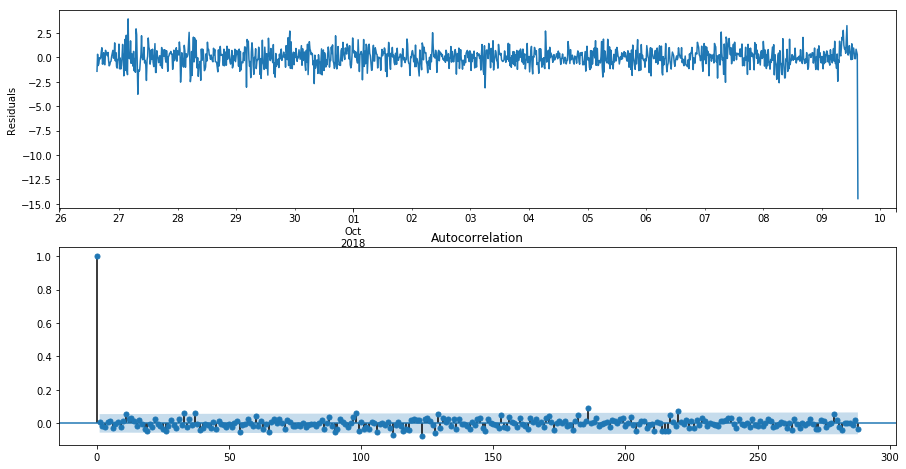

In [24]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[(period+1):].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[(period+1):].values.squeeze(), lags=period*3, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[(period+1):], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[(period+1):])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

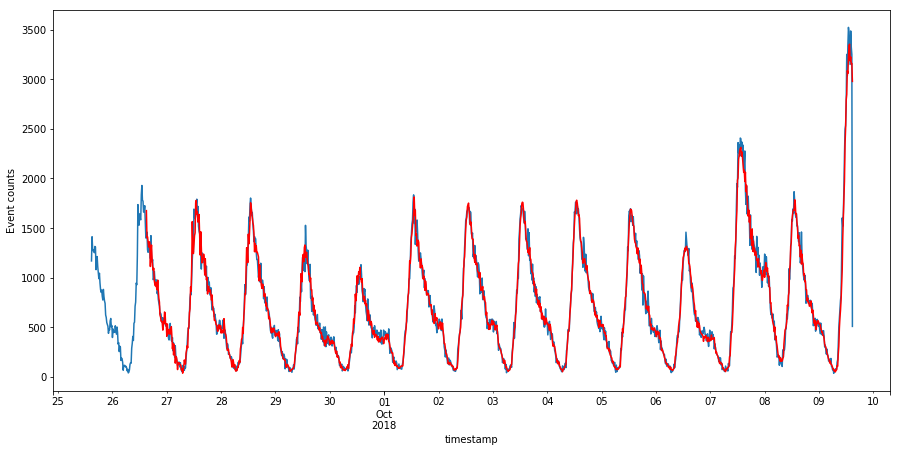

In [25]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
data.eventCount.plot()
data.model[(period+1):].plot(color='r')
plt.ylabel('Event counts')
pylab.show()

### Прогноз

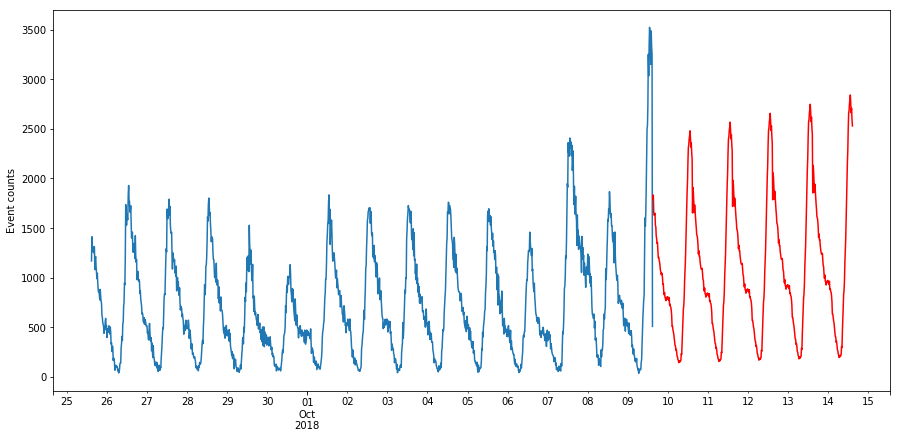

In [26]:
data2 = data[['eventCount']]
date_list = [datetime.datetime.strptime("2018-10-09 14:45", "%Y-%m-%d %H:%M") + relativedelta(seconds=x*15*60) for x in range(1, 4*24*5)]
future = pd.DataFrame(index=date_list, columns=data2.columns)
data2 = pd.concat([data2, future])
data2['forecast'] = invboxcox(best_model.predict(start=len(data.index), end=len(data.index)+4*24*5-1), lmbda)

plt.figure(figsize(15,7))
data2.eventCount.plot()
data2.forecast.plot(color='r')
plt.ylabel('Event counts')
pylab.show()